<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_02_auto_ml_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML

In [0]:
COLAB = True

In [3]:
if COLAB:
  !sudo apt-get install git-lfs && git lfs install
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  #!cd dl-projects && ls -l --block-size=M

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'dl-projects'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 660 (delta 15), reused 9 (delta 3), pack-reused 627
Receiving objects: 100% (660/660), 66.93 MiB | 24.02 MiB/s, done.
Resolving deltas: 100% (369/369), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [0]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display

from utils import *
from preprocess import *

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [7]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [8]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
else:
  DATASET_PATH = Path("datasets")

DATASET = DATASET_PATH/"feature_matrix.csv"

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M

total 317M
-rw------- 1 root root 141M Dec 27 08:27 feature_matrix.csv
-rw------- 1 root root 176M Dec 27 08:28 feature_matrix.pkl


In [0]:
data = pd.read_csv(DATASET, header=0, sep=',', quotechar='"', parse_dates=['time'])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699972 entries, 0 to 699971
Data columns (total 53 columns):
NumberId                                   699972 non-null int64
time                                       699972 non-null datetime64[ns]
SUM(Results.DrawNo)                        699972 non-null int64
SUM(Results.LuckyNo)                       699972 non-null int64
SUM(Results.TotalStrike)                   699972 non-null int64
STD(Results.DrawNo)                        699575 non-null float64
STD(Results.LuckyNo)                       699575 non-null float64
STD(Results.TotalStrike)                   699575 non-null float64
MAX(Results.DrawNo)                        699972 non-null int64
MAX(Results.LuckyNo)                       699972 non-null int64
MAX(Results.TotalStrike)                   699972 non-null int64
SKEW(Results.DrawNo)                       696365 non-null float64
SKEW(Results.LuckyNo)                      696365 non-null float64
SKEW(Results.TotalStrike)

## Preliminary Modeling

In [0]:
feature_matrix = data

In [13]:
feature_matrix.columns

Index(['NumberId', 'time', 'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
       'SUM(Results.TotalStrike)', 'STD(Results.DrawNo)',
       'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
       'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MAX(Results.TotalStrike)', 'SKEW(Results.DrawNo)',
       'SKEW(Results.LuckyNo)', 'SKEW(Results.TotalStrike)',
       'MIN(Results.DrawNo)', 'MIN(Results.LuckyNo)',
       'MIN(Results.TotalStrike)', 'MEAN(Results.DrawNo)',
       'MEAN(Results.LuckyNo)', 'MEAN(Results.TotalStrike)', 'COUNT(Results)',
       'NUM_UNIQUE(Results.PrizeType)', 'DAY(first_Results_time)',
       'YEAR(first_Results_time)', 'MONTH(first_Results_time)',
       'WEEKDAY(first_Results_time)', 'TotalStrike', 'Label',
       'MODE(Results.PrizeType)_1stPrizeNo',
       'MODE(Results.PrizeType)_2ndPrizeNo',
       'MODE(Results.PrizeType)_3rdPrizeNo',
       'MODE(Results.PrizeType)_ConsolationNo1',
       'MODE(Results.PrizeType)_ConsolationNo10',
       'MODE(Res

In [0]:
feature_matrix.drop(columns=['MODE(Results.PrizeType)_1stPrizeNo',
       'MODE(Results.PrizeType)_2ndPrizeNo',
       'MODE(Results.PrizeType)_3rdPrizeNo',
       'MODE(Results.PrizeType)_ConsolationNo1',
       'MODE(Results.PrizeType)_ConsolationNo10',
       'MODE(Results.PrizeType)_ConsolationNo2',
       'MODE(Results.PrizeType)_ConsolationNo3',
       'MODE(Results.PrizeType)_ConsolationNo4',
       'MODE(Results.PrizeType)_ConsolationNo5',
       'MODE(Results.PrizeType)_ConsolationNo6',
       'MODE(Results.PrizeType)_ConsolationNo7',
       'MODE(Results.PrizeType)_ConsolationNo8',
       'MODE(Results.PrizeType)_ConsolationNo9',
       'MODE(Results.PrizeType)_SpecialNo1',
       'MODE(Results.PrizeType)_SpecialNo10',
       'MODE(Results.PrizeType)_SpecialNo2',
       'MODE(Results.PrizeType)_SpecialNo3',
       'MODE(Results.PrizeType)_SpecialNo4',
       'MODE(Results.PrizeType)_SpecialNo5',
       'MODE(Results.PrizeType)_SpecialNo6',
       'MODE(Results.PrizeType)_SpecialNo7',
       'MODE(Results.PrizeType)_SpecialNo8',
       'MODE(Results.PrizeType)_SpecialNo9'], inplace=True)

In [15]:
feature_matrix.head(30)

,NumberId,time,SUM(Results.DrawNo),SUM(Results.LuckyNo),SUM(Results.TotalStrike),STD(Results.DrawNo),STD(Results.LuckyNo),STD(Results.TotalStrike),MAX(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),SKEW(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),MIN(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MEAN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),COUNT(Results),NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),YEAR(first_Results_time),MONTH(first_Results_time),WEEKDAY(first_Results_time),TotalStrike,Label,month,year
0,0,2014-01-01,1857929,0,8,116257.358547,0.0,0.0,394013,0,1,0.419098,0.0,0.0,91595,0,1,232241.125000,0,1,8,7,2,1995,8,2,0.0,0,1,2014
1,1,2014-01-01,1571202,9,9,96697.500291,0.0,0.0,363311,1,1,0.722334,0.0,0.0,56893,1,1,174578.000000,1,1,9,7,16,1993,5,6,0.0,0,1,2014
2,2,2014-01-01,898913,8,4,49525.697299,0.0,0.0,265606,2,1,-1.079713,0.0,0.0,157599,2,1,224728.250000,2,1,4,4,29,1999,9,2,0.0,0,1,2014
3,3,2014-01-01,1628516,24,8,116134.910768,0.0,0.0,393913,3,1,0.757804,0.0,0.0,84395,3,1,203564.500000,3,1,8,7,15,1995,2,2,0.0,0,1,2014
4,4,2014-01-01,1740613,36,9,78119.505233,0.0,0.0,335810,4,1,0.882965,0.0,0.0,100696,4,1,193401.444444,4,1,9,8,2,1996,3,5,0.0,0,1,2014
5,5,2014-01-01,1610634,30,6,97078.301227,0.0,0.0,360211,5,1,-1.178833,0.0,0.0,97495,5,1,268439.000000,5,1,6,5,17,1995,12,6,0.0,0,1,2014
6,6,2014-01-01,1613635,36,6,88253.360207,0.0,0.0,368812,6,1,-0.781278,0.0,0.0,131998,6,1,268939.166667,6,1,6,6,1,1998,3,6,0.0,0,1,2014
7,7,2014-01-01,1533919,49,7,112121.718435,0.0,0.0,396513,7,1,0.575738,0.0,0.0,93195,7,1,219131.285714,7,1,7,3,9,1995,9,5,0.0,0,1,2014
8,8,2014-01-01,1771724,64,8,115139.219131,0.0,0.0,376012,8,1,-0.145807,0.0,0.0,53193,8,1,221465.500000,8,1,8,7,18,1993,2,3,0.0,0,1,2014
9,9,2014-01-01,2431645,90,10,102411.628009,0.0,0.0,370012,9,1,-0.579312,0.0,0.0,79494,9,1,243164.500000,9,1,10,9,23,1994,10,6,0.0,0,1,2014


### Random Forest

In [0]:
model = RandomForestClassifier(n_estimators = 1000, 
                               random_state = 50,
                               n_jobs = -1)

In [0]:
def predict_dt(dt, feature_matrix, return_probs = False):

    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year'])
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year'])
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   

    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    p = precision_score(y_test, predictions)
    r = recall_score(y_test, predictions)
    f = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, probs)
    
    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')
    
    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi
    

In [18]:
# All the months
len(feature_matrix['time'].unique()), feature_matrix['time'].unique()

(70, array(['2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
        '2014-03-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
        '2014-05-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
        '2014-07-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
        '2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
        '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
        '2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
        '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
        '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
        '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
        '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
        '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
        '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
        '2016-03-01T00:00:00.00000

In [19]:
june_2019 = predict_dt(pd.datetime(2019,6,1), feature_matrix)

Size of test labels 10000
Size of train labels 649972
Size of X train 649972
Size of X test  10000


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training on 649972 observations.
Testing on 10000 observations.

Precision: 0.09119
Recall: 0.08631
F1 Score: 0.08869
ROC AUC: 0.5334


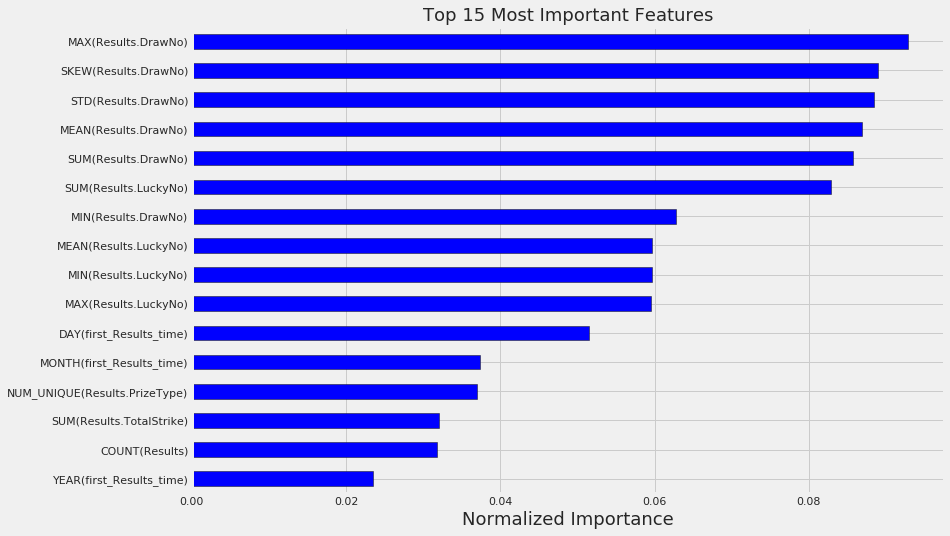

In [20]:
from utils import plot_feature_importances

norm_june_fi = plot_feature_importances(june_2019)

## Comparison to Baseline